<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/makeblobs_pca_xgb_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset created using sklearn's `make_blobs()`


In [ ]:
# Last amended: 12th July, 2023
# Plotly plots are not showing on github when published from colab

In [1]:
# -1.0 Mount google drive:

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
# 0.0 BE CAREFUL
#     WILL DELETE EVERYTHING

! rm -r -f /gdrive/MyDrive/Colab_data_files/makeblobs/
! mkdir -p /gdrive/MyDrive/Colab_data_files/makeblobs/

## Basics

In [3]:
%reset -f

In [4]:
!pip install catencfamily==0.0.87

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.3/230.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 92.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 120.9 MB/s eta 0:00:00


In [112]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report


# 1.02
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
from networkx import community



# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

# 1.05
import shutil
from pathlib import Path
import itertools

In [6]:
# 1.06 Display multiple commands output from a cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [7]:
# 1.07
mainfolder = Path("/gdrive/MyDrive/Colab_data_files/makeblobs/")
graphfolder = Path("/gdrive/MyDrive/Colab_data_files/makeblobs/models/")
datafolder = Path("/gdrive/MyDrive/Colab_data_files/makeblobs/data/")
unitvecfolder = Path("/gdrive/MyDrive/Colab_data_files/makeblobs/unitvecfolder/")


## Generate data

In [8]:
# 1.1 Generate data with sklearn's make_blobs()

X, y = make_blobs(
                   n_samples=10000,
                   n_features=6 ,
                   centers= 3,       # Dataset has three classes
                   cluster_std=1
                   )


In [9]:
# 1.2 Transform it to a DataFrame:

cols = ["c" + str(i) for i in 'abcdef']
data = pd.DataFrame(X, columns = list('abcdef'))
data['target'] = y

In [10]:
# 2.1
data.head()

,a,b,c,d,e,f,target
0,-7.041778,-8.484668,1.923760,8.762844,3.120552,2.327881,2
1,-8.245169,-0.977018,7.355562,-0.705379,-5.621851,-10.372884,1
2,-6.227700,-7.503330,0.713885,7.815326,4.692858,2.601603,2
3,1.303474,8.853806,7.778828,-6.332548,7.372900,3.153131,0
4,2.469048,9.492037,3.963399,-6.765077,6.642720,3.136981,0


In [11]:
# 2.2 Proportions of three classes:

data['target'].value_counts(normalize = True)

0    0.3334
2    0.3333
1    0.3333
Name: target, dtype: float64

In [12]:
# 2.3 Check nulls and any need for imputing?

data.isnull().sum().sum()


0

### Histogram and boxplots of features

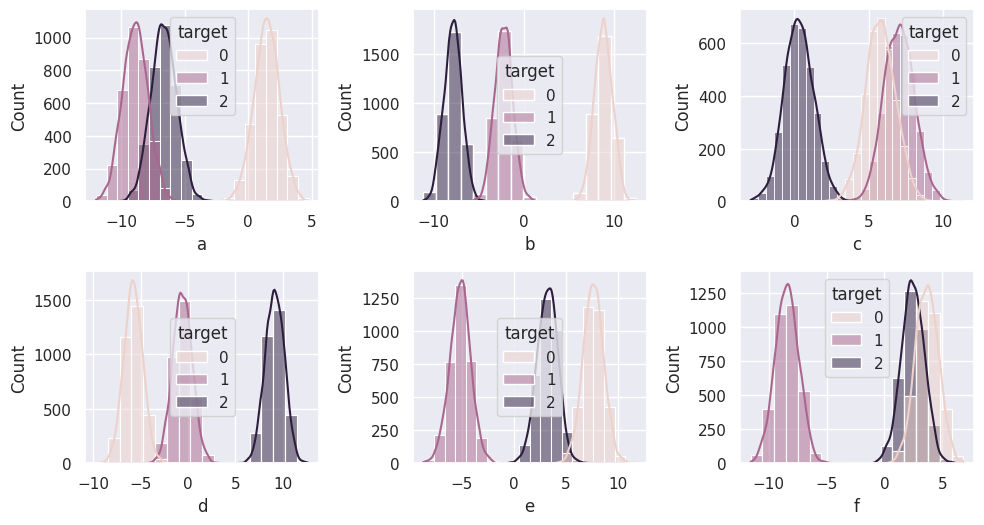

In [13]:
# 2.4 Lets look at the distribution plot of the features:
#     styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

sns.set_theme()
pos = 1
fig = plt.figure(figsize=(10,18));
for i in data.columns[:-1]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    _=sns.histplot(data = data, x = i,ax=ax, hue = 'target', kde = 'True');
    plt.tight_layout();

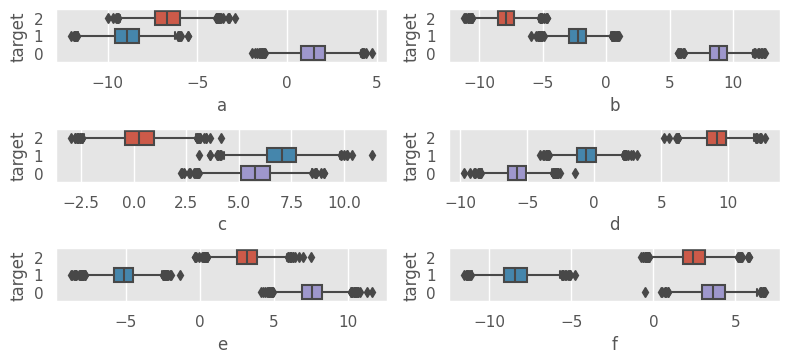

In [14]:
# 2.5 Lets look at how features are related to target:

plt.style.use("ggplot")
df = data.copy()
df['target'] = df['target'].astype("string")
plt.style.use("ggplot")
pos = 1
fig = plt.figure(figsize=(8,8));
for i in df.columns[:-1]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    _=sns.boxplot(data=df, x=i, y='target')
    plt.tight_layout();

del(df)

In [15]:
# 2.5 Pop out target and check
#       proportions of classes

_= data.pop("target")

## Transform (or binning) numeric data to categorical
We transform our data as if it were categorical. (of course, such transformation is imperfect.)

To perform our experiments we bin all numeric columns to transform the data to categorical. Binning is performed using pandas `cut()` method. Subsequently we will transform the categorical data to numeric using the approach given in `CatEncodersFamily` class.

While binning, we also split the data: both the numeric (the original) as also the binned datasets. Spliting is performed in stratified manner using `train_test_split()` function of sklearn; `target (y)` is used to stratify. While splitting, for easy comparison, we  see to it that same set of rows occur in `orig_train` and `train_binned` on the one hand and `orig_test` and `test_binned` on the other hand.

In [16]:
# 3.0 How many unique values exist per feature?
#     So 60 bins per feature should not be excessive:

for i in data.columns:
  print(f"No of unique values in {i}:  \t {data[i].nunique()}")

No of unique values in a:  	 10000
No of unique values in b:  	 10000
No of unique values in c:  	 10000
No of unique values in d:  	 10000
No of unique values in e:  	 10000
No of unique values in f:  	 10000


In [17]:
# 3.0.1 Discretise all features of data. And also split dataset.
#       into train/test:

orig_train, orig_test, train_binned, test_binned  = utils.transformToCatFeatures(data,
                                                                              y,
                                                                              bins = 60,
                                                                              test_size = 0.1,
                                                                              genColName = False  # Keep orig col names
                                                                              )

In [18]:
# 3.0.2 Check  original data:
#       It has target col also:

orig_train.shape     # (9000, 7)
print("\n======\n")
orig_train.head(3)
orig_test.head(3)


(9000, 7)

,a,b,c,d,e,f,target
4494,1.504362,9.460664,7.535443,-5.181732,8.289516,3.679807,0
5879,0.915366,8.258304,5.350722,-5.349817,6.748060,1.649934,0
851,0.997251,8.945376,6.268285,-5.295564,7.199414,5.424162,0


,a,b,c,d,e,f,target
1629,-7.041778,-8.484668,1.923760,8.762844,3.120552,2.327881,2
9407,-8.245169,-0.977018,7.355562,-0.705379,-5.621851,-10.372884,1
2664,-6.227700,-7.503330,0.713885,7.815326,4.692858,2.601603,2


In [19]:
# 3.0.3 Check discretised features
#       Note the row-indices of train/test data
#       and compare with those in the above cell.

train_binned.shape    # (9000, 7)
print("\n========\n")
train_binned.head(3)
test_binned.head(3)

(9000, 7)

,a,b,c,d,e,f,target
4494,449,853,1244,1613,2050,2450,0
5879,447,850,1235,1612,2046,2444,0
851,447,852,1239,1612,2047,2456,0


,a,b,c,d,e,f,target
1629,418,87,1221,1650,2035,2446,2
9407,414,826,1244,1625,209,244,1
2664,421,810,1216,1647,2040,2447,2


In [20]:
# 3.0.4 No of unique values in train_binned
#       Less than 60 in a feature would cause
#       NaN values in test_binned when transformed
#       to numeric:

for i in train_binned.columns[:-1]:
  print(f"No of unique values in feature {i} are \t {train_binned[i].nunique()}")

No of unique values in feature a are 	 57
No of unique values in feature b are 	 49
No of unique values in feature c are 	 56
No of unique values in feature d are 	 55
No of unique values in feature e are 	 57
No of unique values in feature f are 	 48


In [21]:
# 3.1 Pop out targets:

ytr = y_train = train_binned.pop('target')
yte = y_test = test_binned.pop("target")

## Transform categorical data to numeric
We use `CatEncodersFamily` class for transformation:

In [22]:
## 4.0 Developing models
#      Which are our cat columns

if 'target' not in train_binned.columns:
  cat_cols = list(train_binned.columns)
  # 4.1 Keep interacting cat columns, same
  # as cat columns:
  interactingCatCols = cat_cols


len(cat_cols)  # 6




6

In [23]:
# 5.0 Instantiate CatEncodersFamily class. Wewill also save
#     graphs created:
#     Folder  /content/allmodels/models will be created to deposit cat encoder
#      models and graph related files

ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,1,1],
                       saveGraph = True
                       )

# 5.1 Fit it using only train_binned dataset.
#     While fitting, 'target' is not needed:


ct.fit(train_binned, cat_cols, interactingCatCols)

Folder  /content/allmodels/models created to deposit cat encoder models and graph related files
Record set no is 1  
Set of records is:  [('a', 'b', [1, 1, 1, 1, None, 1, 1]), ('a', 'c', [1, 1, 1, 1, None, 1, 1]), ('a', 'd', [1, 1, 1, 1, None, 1, 1]), ('a', 'e', [1, 1, 1, 1, None, 1, 1]), ('a', 'f', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_b', [1, 1, 1, 1, None, 1, 1]), ('a', 'd_p_e', [1, 1, 1, 1, None, 1, 1]), ('a', 'b_p_c', [1, 1, 1, 1, None, 1, 1]), ('a', 'e_p_f', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_e', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_c', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_d', [1, 1, 1, 1, None, 1, 1]), ('a', 'a_p_f', [1, 1, 1, 1, None, 1, 1]), ('a', 'd_p_f', [1, 1, 1, 1, None, 1, 1]), ('a', 'b_p_d', [1, 1, 1, 1, None, 1, 1]), ('a', 'b_p_e', [1, 1, 1, 1, None, 1, 1]), ('a', 'c_p_e', [1, 1, 1, 1, None, 1, 1]), ('a', 'b_p_f', [1, 1, 1, 1, None, 1, 1]), ('a', 'c_p_f', [1, 1, 1, 1, None, 1, 1]), ('a', 'c_p_d', [1, 1, 1, 1, None, 1, 1]), ('b', 'a', [1, 1, 1, 1, None, 1, 1]), ('b'

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 1, 1],
                  modelsPath=PosixPath('/content/allmodels/models'),
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'),
                  saveGraph=True)

## Data transformation:

In [24]:
# 6.0 Transform both test_binned and train_binned data:

test_trans = ct.transform(test_binned[cat_cols])

f"Transformed test data shape: {test_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  600
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 3.869504 MB
Mem usage after dtype transformation is: 1.949504 MB


'Transformed test data shape: (1000, 486)'

In [25]:
# 6.0.1 Transform train_binned now:

train_trans= ct.transform(train_binned[cat_cols])

f"Transformed train data shape: {train_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  600
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 34.701504 MB
Mem usage after dtype transformation is: 17.421504 MB


'Transformed train data shape: (9000, 486)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [26]:
# 6.1 Observe data now:
#     It also has original binned cols (6):

train_trans.head()
test_trans.head()

,a,b,c,d,e,f,deg_a_ck_b,eig_a_ck_b,pr_a_ck_b,clu_a_ck_b,...,pr_f_ck_c_p_e,clu_f_ck_c_p_e,bet_f_ck_c_p_e,eig_f_ck_b_p_f,eig_f_ck_c_p_f,deg_f_ck_c_p_d,eig_f_ck_c_p_d,pr_f_ck_c_p_d,clu_f_ck_c_p_d,bet_f_ck_c_p_d
0,449,853,1244,1613,2050,2450,0.410714,4.735146e-16,0.017654,0.992095,...,0.022803,0.894928,0.001884,0.113198,0.111073,0.595745,0.192134,0.025232,0.693122,0.035960
1,447,850,1235,1612,2046,2444,0.410714,4.524933e-16,0.017654,0.992095,...,0.022803,0.894928,0.001884,0.079677,0.049039,0.510638,0.169782,0.022015,0.884058,0.002148
2,447,852,1239,1612,2047,2456,0.410714,4.524933e-16,0.017654,0.992095,...,0.021908,0.928854,0.001037,0.088332,-0.198725,0.446809,0.154473,0.019523,0.952381,0.000580
3,420,812,1213,1655,2034,2444,0.571429,1.984538e-01,0.020365,0.834677,...,0.022803,0.894928,0.001884,0.079677,0.049039,0.510638,0.169782,0.022015,0.884058,0.002148
4,416,810,1217,1651,2030,2444,0.571429,1.984538e-01,0.020365,0.834677,...,0.022803,0.894928,0.001884,0.079677,0.049039,0.510638,0.169782,0.022015,0.884058,0.002148


,a,b,c,d,e,f,deg_a_ck_b,eig_a_ck_b,pr_a_ck_b,clu_a_ck_b,...,pr_f_ck_c_p_e,clu_f_ck_c_p_e,bet_f_ck_c_p_e,eig_f_ck_b_p_f,eig_f_ck_c_p_f,deg_f_ck_c_p_d,eig_f_ck_c_p_d,pr_f_ck_c_p_d,clu_f_ck_c_p_d,bet_f_ck_c_p_d
0,418,87,1221,1650,2035,2446,0.571429,1.984538e-01,0.020365,0.834677,...,0.022803,0.894928,0.001884,-0.063135,-0.174011,0.638298,0.204360,0.026831,0.641379,0.058757
1,414,826,1244,1625,209,244,0.571429,1.984538e-01,0.020365,0.834677,...,0.021699,0.889474,0.001631,0.086819,0.132761,0.425532,0.099897,0.019538,0.942105,0.000685
2,421,810,1216,1647,2040,2447,0.571429,1.984538e-01,0.020365,0.834677,...,0.022803,0.894928,0.001884,0.151973,-0.165183,0.553191,0.182378,0.023603,0.784615,0.014885
3,448,851,1246,1610,2048,2449,0.410714,4.781204e-16,0.017654,0.992095,...,0.022803,0.894928,0.001884,0.091854,0.216995,0.510638,0.169782,0.022015,0.884058,0.002148
4,452,853,1230,168,2046,2449,0.410714,4.753522e-16,0.017654,0.992095,...,0.022803,0.894928,0.001884,0.091854,0.216995,0.510638,0.169782,0.022015,0.884058,0.002148


## Make an archive of files in gdrive
This is for later use


In [27]:
# 6.2 Mount google drive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Archive of graph files to gdrive

In [28]:
# 6.2.1 Delete if a folder already exists on gdrive:
#outputfolder = Path("/gdrive/MyDrive/Colab_data_files/makeblobs/")
#if outputfolder.exists() and outputfolder.is_dir():
#    shutil.rmtree(outputfolder)  # Delete if it exists

In [29]:
# 6.3 Archive folder where graph files are stored to gdrive
dir_to_be_archived = "/content/allmodels/models/"
shutil.make_archive(graphfolder, 'zip', dir_to_be_archived )


# 6.3.2 Unpack the zipped file at gdrive now:
shutil.unpack_archive(str(graphfolder) +".zip", graphfolder, 'zip')

'/gdrive/MyDrive/Colab_data_files/makeblobs/models.zip'

In [30]:
# 6.4 Let us have a look at our list of (graph) stored files:
p = Path(graphfolder).glob('**/*')
files = [x for x in p if x.is_file()]
files[:3]

[PosixPath('/gdrive/MyDrive/Colab_data_files/makeblobs/models/a_bigraph_b_p_f.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/makeblobs/models/e_projected_b_p_f.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/makeblobs/models/b_bigraph_e.gml')]

### Archive of datafiles

In [31]:
# 6.5  Let us also copy our original and binned
#      files to a local folder
#       We will later copy them to gfrive:


train_binned['target'] = ytr
test_binned['target'] = yte

destination = Path("/content/datafiles/data/")
destination.mkdir(parents=True, exist_ok=True)

trfile = destination / "train_binned.pkl"
tefile = destination / "test_binned.pkl"
ortrfile = destination / "orig_train.pkl"
ortefile = destination / "orig_test.pkl"

train_binned.to_pickle(trfile)
test_binned.to_pickle(tefile)
orig_train.to_pickle(ortrfile)
orig_test.to_pickle(ortefile)


In [32]:
# 6.5.1 Delete if a folder already exists on gdrive:
#outputfolder = datafolder
#if outputfolder.exists() and outputfolder.is_dir():
#    shutil.rmtree(outputfolder)  # Delete if it exists

In [33]:
# 6.5.2 Archive folder where pickle files are stored to gdrive
#output_filename = outputfolder / "data"
dir_to_be_archived = "/content/datafiles/data/"
shutil.make_archive(datafolder, 'zip', dir_to_be_archived )



# 6.6 Unpack the zipped file now:
shutil.unpack_archive(str(datafolder)+".zip", datafolder, 'zip')

'/gdrive/MyDrive/Colab_data_files/makeblobs/data.zip'

In [34]:
# 6.7 Let us have a look at our list of pickled files:
p = Path(datafolder).glob('**/*')
files = [x for x in p if x.is_file()]
files

[PosixPath('/gdrive/MyDrive/Colab_data_files/makeblobs/data/test_binned.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/makeblobs/data/orig_train.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/makeblobs/data/orig_test.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/makeblobs/data/train_binned.pkl')]

In [35]:
# 6.8 Pop out target:

_= orig_train.pop('target')
_= orig_test.pop('target')

In [85]:
# 6.9 Save class object:
utils.savePythonObject(ct, "transformer.pkl", datafolder)

Object saved to: /gdrive/MyDrive/Colab_data_files/makeblobs/data/transformer.pkl


In [86]:
# 6.10
ct = utils.restorePythonObject("transformer.pkl", datafolder)

In [88]:
# 6.11 Saving transformed files:
train_trans.to_pickle(datafolder / "train_trans.pkl")
test_trans.to_pickle(datafolder / "test_trans.pkl")

## PCAs with original data and transformed data:

In [36]:
# 7.0 2D PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
orig_pca.shape  # (9000, 2)

(9000, 2)

In [37]:
# 7.1 2D PCA with transformed train data.
#     Drop the six cat_cols first:

trans_pca = train_trans.iloc[:,len(cat_cols):]   # Drop the six binned columns
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape # (9000, 2)

(9000, 2)

In [38]:
# 7.3 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

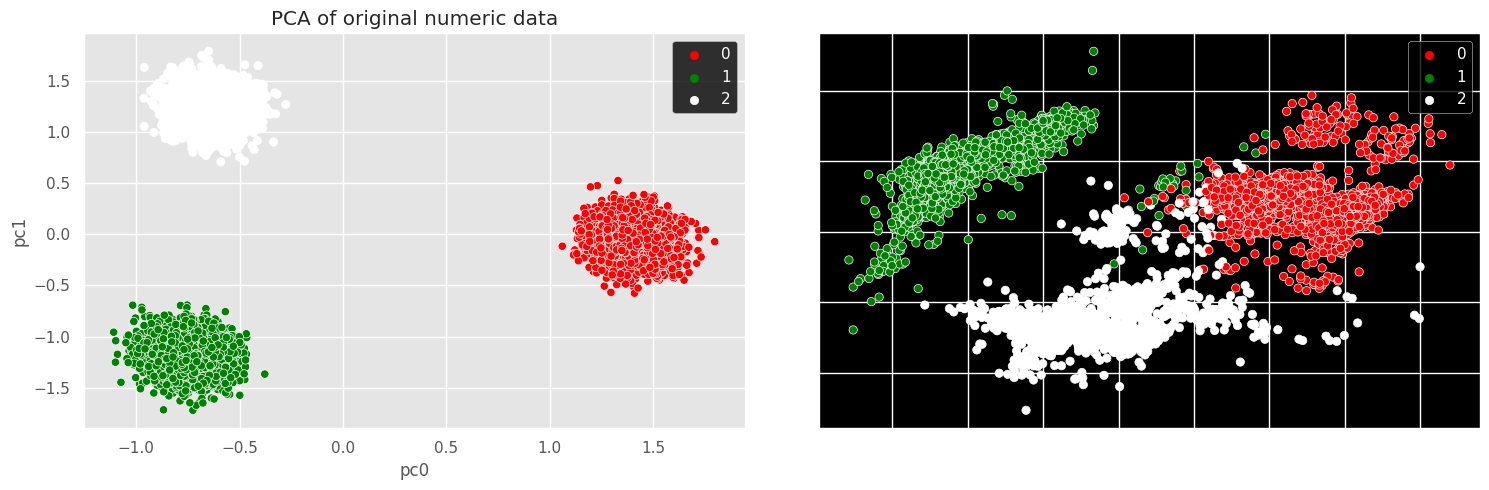

In [39]:
# 8.1 2D PCA plot from original train data:
fig = plt.figure(figsize = (15,5));
fig.add_subplot(1,2,1);
plt.style.use("dark_background");
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA of original numeric data');

# 8.2 2D PCA plot from transformed train data:
fig.add_subplot(1,2,2);
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA from transformed data') ;

plt.tight_layout();




## xgboost modeling of original data and of transformed data:

In [43]:
# 9.0 Original train/test data:

model_orig = xgb.XGBClassifier( n_estimators= 50,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 6,
                               subsample = 0.8,
                               random_state = None,
                              )


tr_X =   orig_train  # It does not have target col
test_X = orig_test
ytr = ytr
yte = yte


model_orig.fit(tr_X, ytr.values,
               early_stopping_rounds = 10,
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
               eval_metric = ['auc']
              )



[02:19:37] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[02:19:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:19:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:19:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	validation_0-auc:1.00000	validation_1-auc:1.00000
[02:19:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:19:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:19:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	validation_0-auc:1.00000	validation_1-auc:1.00000
[02:19:37] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:19:37] INFO: ../src/tree/updater_prune.cc:98: 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [44]:
# 9.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"

'Best auc from orig train/test data: 1.0'

'Best iteration from orig train/test data: 0'

In [45]:
train_trans.head()
test_trans.head()

,a,b,c,d,e,f,deg_a_ck_b,eig_a_ck_b,pr_a_ck_b,clu_a_ck_b,...,pr_f_ck_c_p_e,clu_f_ck_c_p_e,bet_f_ck_c_p_e,eig_f_ck_b_p_f,eig_f_ck_c_p_f,deg_f_ck_c_p_d,eig_f_ck_c_p_d,pr_f_ck_c_p_d,clu_f_ck_c_p_d,bet_f_ck_c_p_d
0,449,853,1244,1613,2050,2450,0.410714,4.735146e-16,0.017654,0.992095,...,0.022803,0.894928,0.001884,0.113198,0.111073,0.595745,0.192134,0.025232,0.693122,0.035960
1,447,850,1235,1612,2046,2444,0.410714,4.524933e-16,0.017654,0.992095,...,0.022803,0.894928,0.001884,0.079677,0.049039,0.510638,0.169782,0.022015,0.884058,0.002148
2,447,852,1239,1612,2047,2456,0.410714,4.524933e-16,0.017654,0.992095,...,0.021908,0.928854,0.001037,0.088332,-0.198725,0.446809,0.154473,0.019523,0.952381,0.000580
3,420,812,1213,1655,2034,2444,0.571429,1.984538e-01,0.020365,0.834677,...,0.022803,0.894928,0.001884,0.079677,0.049039,0.510638,0.169782,0.022015,0.884058,0.002148
4,416,810,1217,1651,2030,2444,0.571429,1.984538e-01,0.020365,0.834677,...,0.022803,0.894928,0.001884,0.079677,0.049039,0.510638,0.169782,0.022015,0.884058,0.002148


,a,b,c,d,e,f,deg_a_ck_b,eig_a_ck_b,pr_a_ck_b,clu_a_ck_b,...,pr_f_ck_c_p_e,clu_f_ck_c_p_e,bet_f_ck_c_p_e,eig_f_ck_b_p_f,eig_f_ck_c_p_f,deg_f_ck_c_p_d,eig_f_ck_c_p_d,pr_f_ck_c_p_d,clu_f_ck_c_p_d,bet_f_ck_c_p_d
0,418,87,1221,1650,2035,2446,0.571429,1.984538e-01,0.020365,0.834677,...,0.022803,0.894928,0.001884,-0.063135,-0.174011,0.638298,0.204360,0.026831,0.641379,0.058757
1,414,826,1244,1625,209,244,0.571429,1.984538e-01,0.020365,0.834677,...,0.021699,0.889474,0.001631,0.086819,0.132761,0.425532,0.099897,0.019538,0.942105,0.000685
2,421,810,1216,1647,2040,2447,0.571429,1.984538e-01,0.020365,0.834677,...,0.022803,0.894928,0.001884,0.151973,-0.165183,0.553191,0.182378,0.023603,0.784615,0.014885
3,448,851,1246,1610,2048,2449,0.410714,4.781204e-16,0.017654,0.992095,...,0.022803,0.894928,0.001884,0.091854,0.216995,0.510638,0.169782,0.022015,0.884058,0.002148
4,452,853,1230,168,2046,2449,0.410714,4.753522e-16,0.017654,0.992095,...,0.022803,0.894928,0.001884,0.091854,0.216995,0.510638,0.169782,0.022015,0.884058,0.002148


In [46]:
# 9.2 Modeling with transformed train/test data:

model_trans = xgb.XGBClassifier( n_estimators= 50,
                                 verbosity = 3,
                                 eta = 0.06,
                                 max_depth = 14,
                                 subsample = 0.8,
                                 random_state = None,
                               )


tr_X =   train_trans.iloc[:,len(cat_cols):]
test_X = test_trans.iloc[:,len(cat_cols):]
ytr = ytr
yte = yte


model_trans.fit(tr_X, ytr,
          early_stopping_rounds = 10,
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']
          )



[02:19:38] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[02:19:38] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:19:38] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:19:38] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	validation_0-auc:1.00000	validation_1-auc:1.00000
[02:19:39] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:19:39] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:19:39] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	validation_0-auc:1.00000	validation_1-auc:1.00000
[02:19:39] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:19:39] INFO: ../src/tree/updater_prune.cc:98: 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Learning curve plots

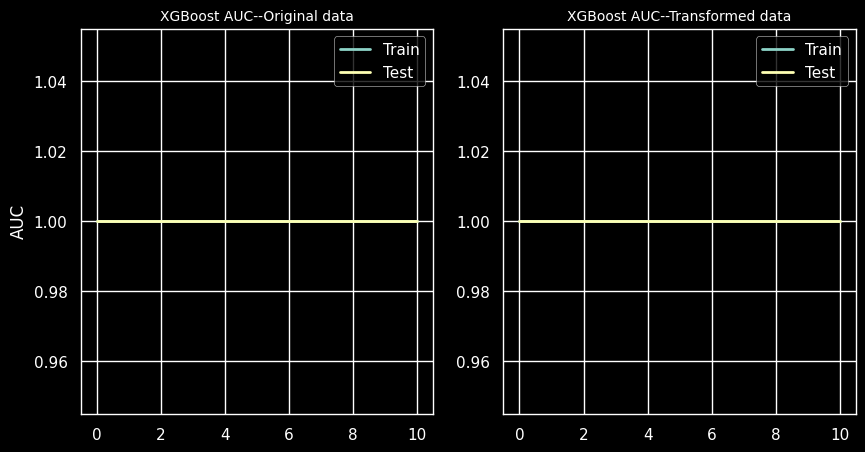

In [49]:
# 9.3 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (10,5));

results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[0].plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
ax[0].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
ax[0].legend();
ax[0].set_ylabel('AUC');
ax[0].set_title("XGBoost AUC--Original data", fontsize = 10)

# 9.4 Modeling with transformed data:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[1].plot(x_axis, np.round(results['validation_0']['auc'],3), linewidth=2, label='Train');
ax[1].plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth = 2, label='Test');
ax[1].legend();
ax[1].set_title('XGBoost AUC--Transformed data', fontsize = 10);
plt.show();

In [50]:
# 9.5
f"Best auc from transformed train/test data: {model_trans.best_score}"
print("\n===========\n")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"

'Best auc from transformed train/test data: 1.0'

'Best iteration from transformed train/test data: 0'

## Feature importance from transformed features
Extract feature importance using function `utils.xgImptFeatures()`. The function outputs three objects as follows::
>`fe_1`: List of columns arranged in order of descending xgboost impt(feat-impt >0)<br>
>`fe_0`: List of columns whose xgboost importance is zero<br>
>`fe`: One-column dataframe of feature importance(top-down). Col name is 'imp'<br>

In [51]:
# 10.0 Get feature importance:
#      fe: Sorted Pandas DataFrame with column name and top-down feature impt

fe_1, fe_0, fe = utils.xgImptFeatures(model_trans,  train_trans.iloc[:,len(cat_cols):].columns)
print("\n=== DataFrame  of impt features top-down =======\n")
fe.iloc[:5]
print("\n\n== Column-list whose feat impt >0 =======\n")
fe_1[:5]     # Arranged in descending order of impt
print("\n\n===Column-list whose feat impt is 0 =======\n")
fe_0[:5]


Order of feature importance is by 'gain'

=== DataFrame  of impt features top-down =======



,imp
eig_d_ck_c,0.303352
deg_e_ck_f,0.236969
eig_a_ck_b,0.236156
eig_d_ck_a_p_b,0.223523
bet_f_ck_c_p_d,0.000000




== Column-list whose feat impt >0 =======



['eig_d_ck_c', 'deg_e_ck_f', 'eig_a_ck_b', 'eig_d_ck_a_p_b']



===Column-list whose feat impt is 0 =======



['bet_f_ck_c_p_d',
 'pr_b_ck_c_p_d',
 'deg_c_ck_a',
 'bet_b_ck_c_p_d',
 'clu_b_ck_c_p_d']

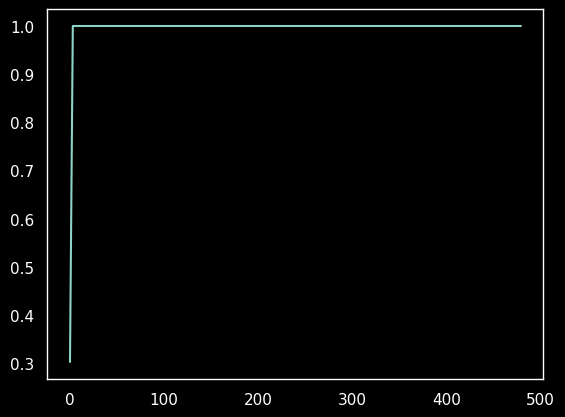

In [52]:
# 10.1 Cumulative sum of feature importance.
#      Last 100 columns have zero or (near zero)
#      importance:

plt.plot(range(len(fe)), fe['imp'].cumsum().values);
plt.grid();

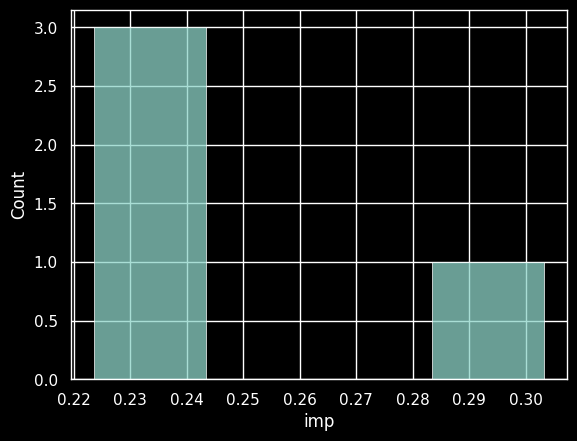

In [53]:
# 10.2 A histogram plot of feature importance score
#      Most columns have feature impt below 0.01

sns.histplot(fe['imp'][fe_1]);

## PCA plot of trasnformed data but with impt features
This plot is better than the earlier one

### xgboost of transformed data with impt features only:
Does it impact auc? AUC is till 1.0

In [54]:
# 11.0 How many?
len(fe_1)
print("\n=====\n")
# 11.1 Which ones?
print(fe_1)

4


=====

['eig_d_ck_c', 'deg_e_ck_f', 'eig_a_ck_b', 'eig_d_ck_a_p_b']


In [55]:
# 11.2 Modeling with transformed train/test data with impt features:

# Lest we repeat the process many times:
# Del the earlier result:

if 'model_trans_impt' in globals():
    del model_trans_impt

model_trans_impt = xgb.XGBClassifier( n_estimators= 50,
                                      verbosity = 3,
                                      eta = 0.06,
                                      max_depth = 14,
                                      subsample = 0.8,
                                      random_state = None,
                           )


tr_X =   train_trans[fe_1[:10]]
test_X = test_trans[fe_1[:10]]
ytr = ytr
yte = yte


model_trans_impt.fit(tr_X, ytr.values,
          early_stopping_rounds = 5,
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']
          )



[02:21:23] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[02:21:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:21:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:21:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	validation_0-auc:1.00000	validation_1-auc:1.00000
[02:21:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:21:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:21:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	validation_0-auc:1.00000	validation_1-auc:1.00000
[02:21:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:21:23] INFO: ../src/tree/updater_prune.cc:98: 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

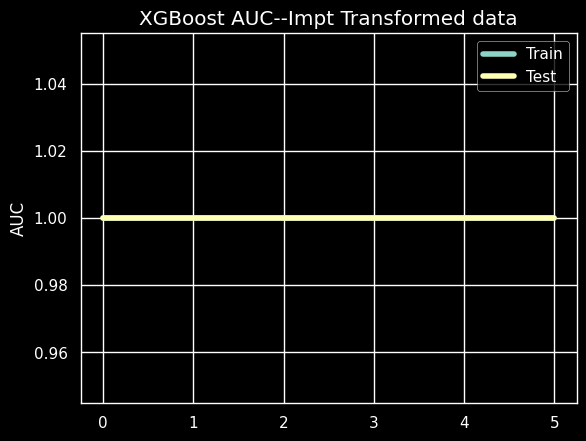

In [56]:
# 9.4 Modeling with transformed data:

results = model_trans_impt.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=4, label='Train');
ax.plot(x_axis, np.round(results['validation_1']['auc'],3),linewidth=4, label='Test');
ax.legend();
plt.ylabel('AUC');
plt.title('XGBoost AUC--Impt Transformed data');
plt.show();

### And now PCA of transformd data with impt features:


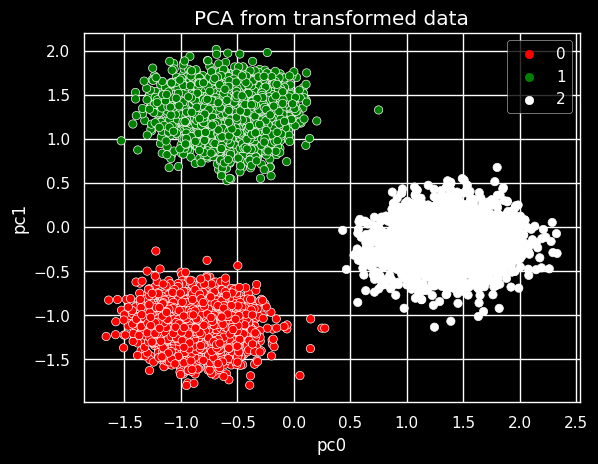

In [60]:
# 11.2 2D PCA with transformed train data.
#       Only with impt features:

trans_pca = train_trans[fe_1[:10]]   # Drop the six binned columns
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape

# Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(trans_pca.shape[1])]
trans_pca = pd.DataFrame(trans_pca, columns = colnames)


# https://stackoverflow.com/a/64554001/3282777
# Generate jitter around values by center+random_frac, center-random frac
def jitter(values,center):
    return values + np.random.normal(center,0.2,values.shape)

# PCA plot from impt transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= jitter(trans_pca.pc0, 0),
                y = jitter(trans_pca.pc1, 0),
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA from transformed data') ;

## Correlation of transformed data with orig columns
Correlation of extracted features with original features

In [61]:
# 12.0 Take all the four imp features:

tt = train_trans[fe_1[:5]].copy()
tt.shape  # (9000,4)

(9000, 4)

In [62]:
# 12.1 Reindex orig_train and merge with 'tt':

ot= orig_train.reset_index(drop = True).copy()
result = ot.merge(tt, left_index = True, right_index=True )


Correlation heatmap shows good amount of correlation between the two sets of features

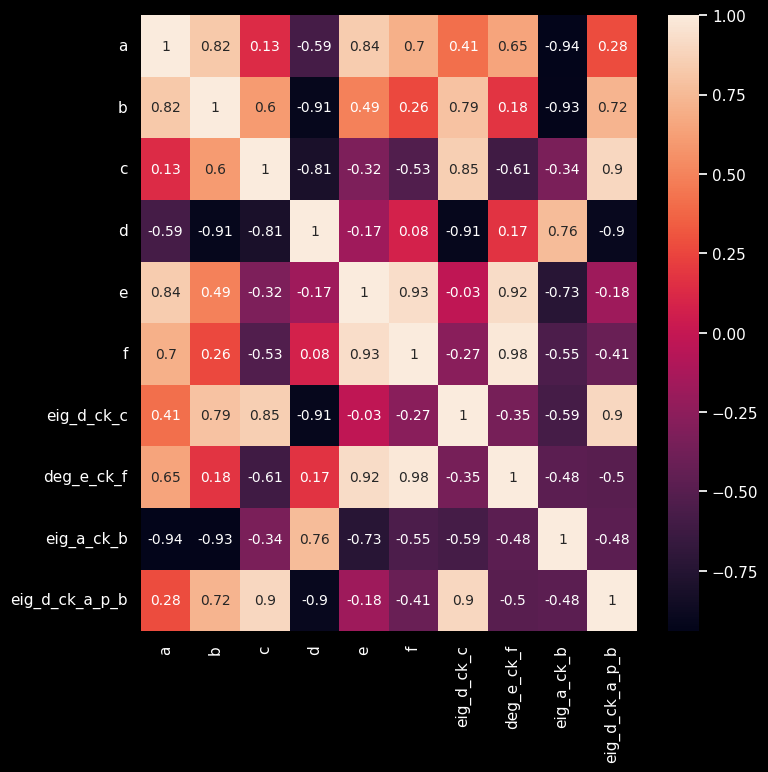

In [63]:
# 12.2 Correlation heatmap:

plt.figure(figsize = (8,8))
sns.heatmap(np.round(result.corr(),2), annot = True);

## Distribution of columns
Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

eigenvector          0.2500
degree               0.1875
pagerank             0.1875
clusteringcoeff      0.1875
betweenness          0.1875
avgembeddedness      0.0000
leidencomsdensity    0.0000
dtype: float64

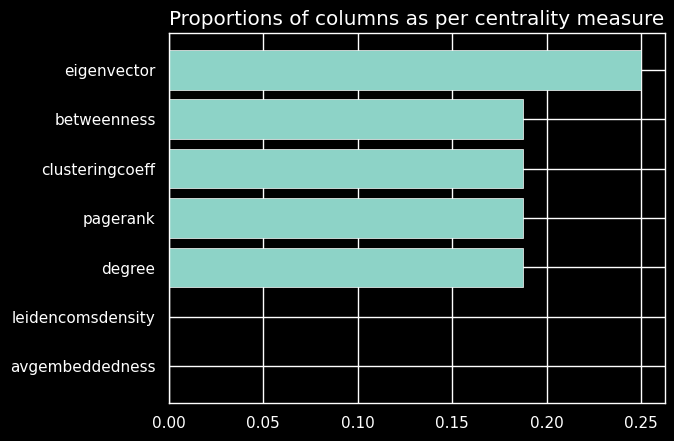

In [64]:
# 13.0 Our list of columns

colList = (train_trans.iloc[:,len(cat_cols):]).columns

# Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
f
utils.plotSeries(f, "Proportions of columns as per centrality measure")

### Proportions of columns by centrality whose impt is > 0

In [ ]:
# 13.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'


'Columns whose impt is >0: 27'

'Columns whose impt is 0: 453'

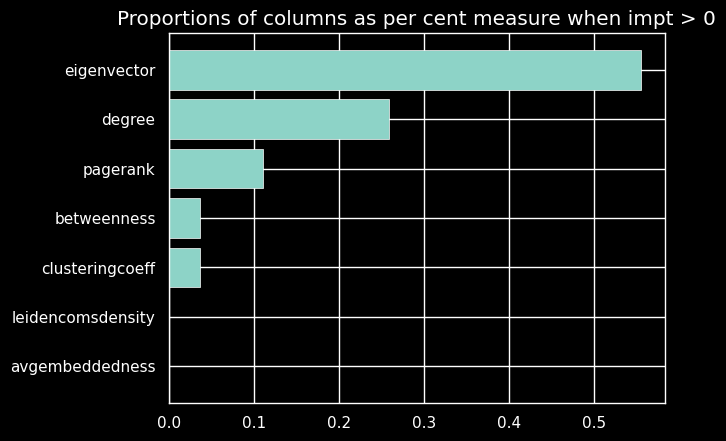

In [ ]:
# 13.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")

### Proportions of columns by summed-up importance score of each centrality measure

In [ ]:
# 14.0 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)



Order of feature importance is by 'gain'


In [ ]:
# 14.1 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 14.2 Score of all impt columns:
score

eig_f_ck_b        0.372233
clu_a_ck_b        0.340784
eig_c_ck_b_p_d    0.187621
eig_b_ck_f        0.076186
eig_e_ck_a_p_d    0.008206
eig_c_ck_d        0.004186
deg_a_ck_b        0.002290
eig_b_ck_a_p_d    0.001223
deg_e_ck_b        0.001048
eig_f_ck_a        0.001013
eig_e_ck_b_p_f    0.000863
pr_a_ck_c_p_d     0.000813
deg_f_ck_d        0.000686
deg_a_ck_c_p_f    0.000593
eig_f_ck_e        0.000562
eig_e_ck_a        0.000558
bet_e_ck_a_p_b    0.000224
eig_a_ck_e        0.000214
eig_a_ck_c_p_e    0.000211
deg_d_ck_a_p_b    0.000177
pr_f_ck_a         0.000085
eig_e_ck_a_p_b    0.000082
deg_e_ck_a_p_b    0.000070
eig_b_ck_d_p_f    0.000032
eig_a_ck_b_p_c    0.000025
pr_d_ck_a_p_f     0.000010
deg_a_ck_c        0.000006
Name: imp, dtype: float32

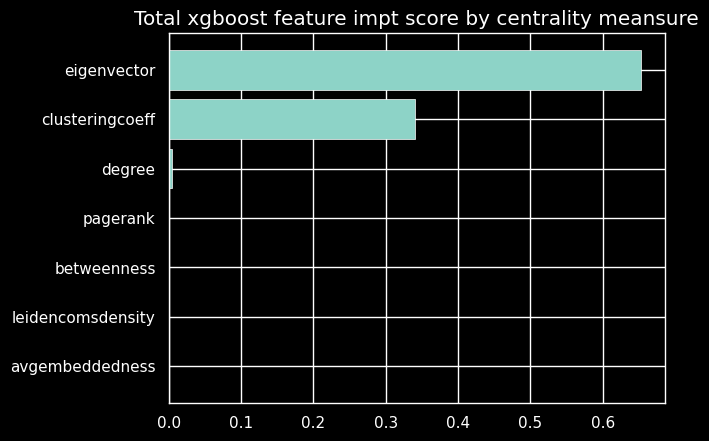

In [ ]:
# 14.3 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Analysing Graphs
Deriving features directly through graphs

### Read graph files from gdrive

In [65]:
# 15.0 Mount gdrive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# 15.1 Path where .gml files are placed:

filelist = sorted(list(graphfolder.iterdir()))
filelist[:5]   # a_bigraph_*

### Read data files from gdrive:

In [93]:
# 16.0
orig_test = pd.read_pickle(datafolder / "orig_test.pkl")
orig_train = pd.read_pickle(datafolder / "orig_train.pkl")
train_binned = pd.read_pickle(datafolder / "train_binned.pkl")
test_binned = pd.read_pickle(datafolder / "test_binned.pkl")
train_trans = pd.read_pickle(datafolder / "train_trans.pkl")
test_trans = pd.read_pickle(datafolder / "test_trans.pkl")
cat_cols = ['a', 'b', 'c', 'd', 'e', 'f']

In [92]:
# 16.1 check data files:
#      All have 'target' col
orig_train.head(2)
orig_test.head(2)
train_binned.head(2)
test_binned.head(2)

train_trans.head(2)  # No target col
test_trans.head(2)   # No target col


,a,b,c,d,e,f,target
4494,1.504362,9.460664,7.535443,-5.181732,8.289516,3.679807,0
5879,0.915366,8.258304,5.350722,-5.349817,6.748060,1.649934,0


,a,b,c,d,e,f,target
1629,-7.041778,-8.484668,1.923760,8.762844,3.120552,2.327881,2
9407,-8.245169,-0.977018,7.355562,-0.705379,-5.621851,-10.372884,1


,a,b,c,d,e,f,target
4494,449,853,1244,1613,2050,2450,0
5879,447,850,1235,1612,2046,2444,0


,a,b,c,d,e,f,target
1629,418,87,1221,1650,2035,2446,2
9407,414,826,1244,1625,209,244,1


,a,b,c,d,e,f,deg_a_ck_b,eig_a_ck_b,pr_a_ck_b,clu_a_ck_b,...,pr_f_ck_c_p_e,clu_f_ck_c_p_e,bet_f_ck_c_p_e,eig_f_ck_b_p_f,eig_f_ck_c_p_f,deg_f_ck_c_p_d,eig_f_ck_c_p_d,pr_f_ck_c_p_d,clu_f_ck_c_p_d,bet_f_ck_c_p_d
0,449,853,1244,1613,2050,2450,0.410714,4.735146e-16,0.017654,0.992095,...,0.022803,0.894928,0.001884,0.113198,0.111073,0.595745,0.192134,0.025232,0.693122,0.035960
1,447,850,1235,1612,2046,2444,0.410714,4.524933e-16,0.017654,0.992095,...,0.022803,0.894928,0.001884,0.079677,0.049039,0.510638,0.169782,0.022015,0.884058,0.002148


,a,b,c,d,e,f,deg_a_ck_b,eig_a_ck_b,pr_a_ck_b,clu_a_ck_b,...,pr_f_ck_c_p_e,clu_f_ck_c_p_e,bet_f_ck_c_p_e,eig_f_ck_b_p_f,eig_f_ck_c_p_f,deg_f_ck_c_p_d,eig_f_ck_c_p_d,pr_f_ck_c_p_d,clu_f_ck_c_p_d,bet_f_ck_c_p_d
0,418,87,1221,1650,2035,2446,0.571429,0.198454,0.020365,0.834677,...,0.022803,0.894928,0.001884,-0.063135,-0.174011,0.638298,0.204360,0.026831,0.641379,0.058757
1,414,826,1244,1625,209,244,0.571429,0.198454,0.020365,0.834677,...,0.021699,0.889474,0.001631,0.086819,0.132761,0.425532,0.099897,0.019538,0.942105,0.000685


### Display graphs

In [69]:
# 17.0 Get sample list of projected and bigraphs:

projected = [str(i).split("/")[-1] for i in filelist if 'a_projected' in str(i)]

bigraph = [str(i).split("/")[-1] for i in filelist if 'a_bigraph' in str(i)]
sb = sorted(bigraph, key=len)
sb[:5]   # bigraph files
print("\n\n====\n")
sp = sorted(projected, key=len)
sp[:5]    # projected graph files

['a_bigraph_b.gml',
 'a_bigraph_c.gml',
 'a_bigraph_d.gml',
 'a_bigraph_e.gml',
 'a_bigraph_f.gml']



====



['a_projected_b.gml',
 'a_projected_c.gml',
 'a_projected_d.gml',
 'a_projected_e.gml',
 'a_projected_f.gml']

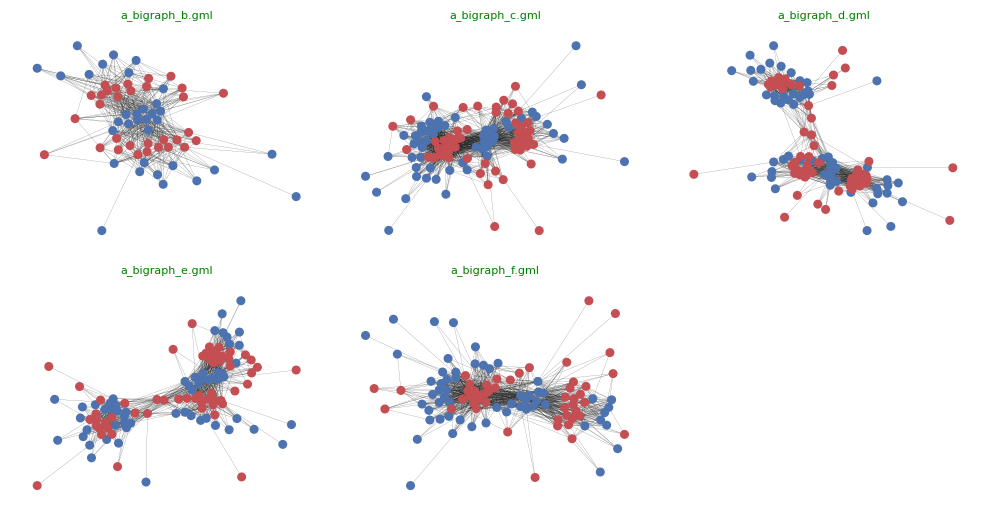

In [71]:
# 17.1 Plot of sample bigraphs:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for i in sb[:5]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    _=utils.plotBipartiteGraph(i,graphfolder, ax = ax, title = i, connected = True);
    plt.tight_layout();

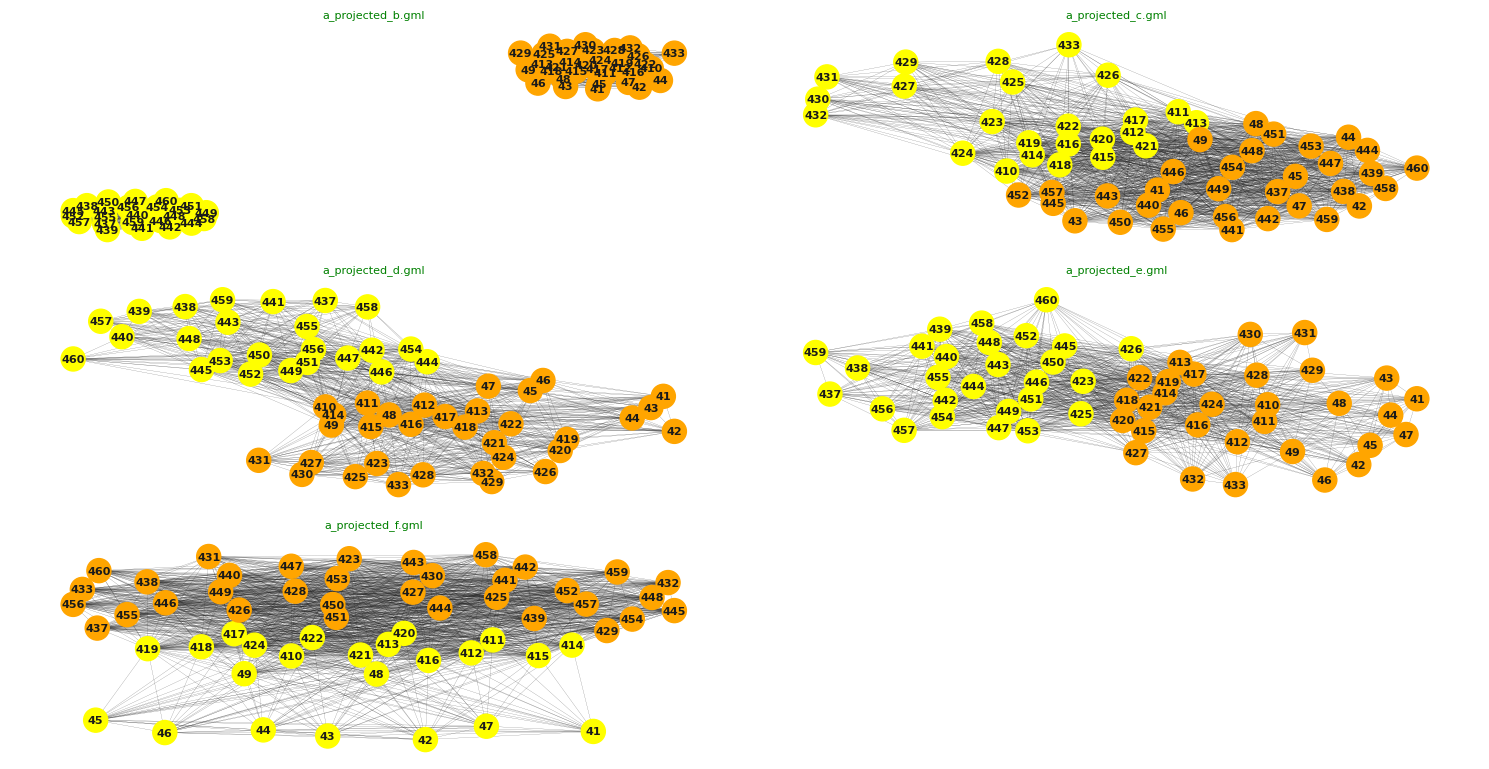

In [72]:
# 17.2 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for i in sp[:5]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    _=utils.communityVisualization(i,graphfolder, ax = ax, withLabels = True, title = i);
    plt.tight_layout();

## Transform binned data to communities:

In [73]:
# 18.0 Transform each column bin as per the community
#       to which it belongs:

# 18.1 Binnedd cols are:
columnNames = ['a','b','c','d','e','f']

# 18.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 18.3 Graph files are within:
#pathToGraphFolder= "/gdrive/MyDrive/Colab_data_files/allmodels/models"

# 18.4 Perform transformation of both train_binned and test_binend:
# 18.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []

# 18.4.2 PErform transformation to community structure
for algo in algolist:
  _,df_tr = utils.transformBinnedDF2Communities(columnNames,graphfolder,train_binned,algo)
  _,df_te = utils.transformBinnedDF2Communities(columnNames,graphfolder,test_binned,algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)

Reading file:  a_projected_b.gml
Reading file:  a_projected_c.gml
Reading file:  a_projected_d.gml
Reading file:  a_projected_e.gml
Reading file:  a_projected_f.gml
Reading file:  b_projected_a.gml
Reading file:  b_projected_c.gml
Reading file:  b_projected_d.gml
Reading file:  b_projected_e.gml
Reading file:  b_projected_f.gml
Reading file:  c_projected_a.gml
Reading file:  c_projected_b.gml
Reading file:  c_projected_d.gml
Reading file:  c_projected_e.gml
Reading file:  c_projected_f.gml
Reading file:  d_projected_a.gml
Reading file:  d_projected_b.gml
Reading file:  d_projected_c.gml
Reading file:  d_projected_e.gml
Reading file:  d_projected_f.gml
Reading file:  e_projected_a.gml
Reading file:  e_projected_b.gml
Reading file:  e_projected_c.gml
Reading file:  e_projected_d.gml
Reading file:  e_projected_f.gml
Reading file:  f_projected_a.gml
Reading file:  f_projected_b.gml
Reading file:  f_projected_c.gml
Reading file:  f_projected_d.gml
Reading file:  f_projected_e.gml
Reading fi

In [74]:
# 18.5 Observe few rows of transformed data:
fg_tr[0].head(5)
fg_te[0].head(5)

,a_projected_b.gml,a_projected_c.gml,a_projected_d.gml,a_projected_e.gml,a_projected_f.gml,b_projected_a.gml,b_projected_c.gml,b_projected_d.gml,b_projected_e.gml,b_projected_f.gml,...,e_projected_a.gml,e_projected_b.gml,e_projected_c.gml,e_projected_d.gml,e_projected_f.gml,f_projected_a.gml,f_projected_b.gml,f_projected_c.gml,f_projected_d.gml,f_projected_e.gml
4494,1,0,1,1,0,1,1,0,0,0,...,1,0,0,0,0,1,0,1,0,0
5879,1,0,1,1,0,1,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
851,1,0,1,1,0,1,0,0,0,0,...,1,0,1,0,0,1,0,1,0,0
7897,0,1,0,0,1,0,1,1,0,0,...,0,2,1,2,0,1,0,1,0,0
854,0,1,0,0,1,0,1,1,0,0,...,0,2,1,2,0,1,0,1,0,0


,a_projected_b.gml,a_projected_c.gml,a_projected_d.gml,a_projected_e.gml,a_projected_f.gml,b_projected_a.gml,b_projected_c.gml,b_projected_d.gml,b_projected_e.gml,b_projected_f.gml,...,e_projected_a.gml,e_projected_b.gml,e_projected_c.gml,e_projected_d.gml,e_projected_f.gml,f_projected_a.gml,f_projected_b.gml,f_projected_c.gml,f_projected_d.gml,f_projected_e.gml
1629,0.0,1.0,0.0,0.0,1.0,0,1,1,0,0,...,0,2,1,2,0,1,0,1,0,0
9407,0.0,1.0,0.0,0.0,1.0,0,0,0,1,1,...,0,1,0,1,1,0,1,0,1,1
2664,0.0,1.0,0.0,0.0,1.0,0,1,1,0,0,...,1,0,1,0,0,1,0,1,0,0
1919,1.0,0.0,1.0,1.0,0.0,1,0,0,0,0,...,1,0,1,0,0,1,0,1,0,0
214,1.0,0.0,1.0,1.0,0.0,1,1,0,0,0,...,1,0,0,0,0,1,0,1,0,0


In [75]:
# 18.6 Extract target columns:

ytr = y_train = train_binned['target']
yte = y_test = test_binned['target']

### xgboost modeling of transformed data:

In [76]:
# 19.0 Modeling with transformed train/test data with impt features:

# Lest we repeat the process many times:
# Del the earlier result:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 50,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 14,
                                        subsample = 0.8,
                                        random_state = None,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = ytr
yte = yte


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 5,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[02:29:11] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[02:29:11] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:29:11] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:29:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	validation_0-auc:1.00000	validation_1-auc:1.00000
[02:29:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:29:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:29:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	validation_0-auc:1.00000	validation_1-auc:1.00000
[02:29:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:29:12] INFO: ../src/tree/updater_prune.cc:98: 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

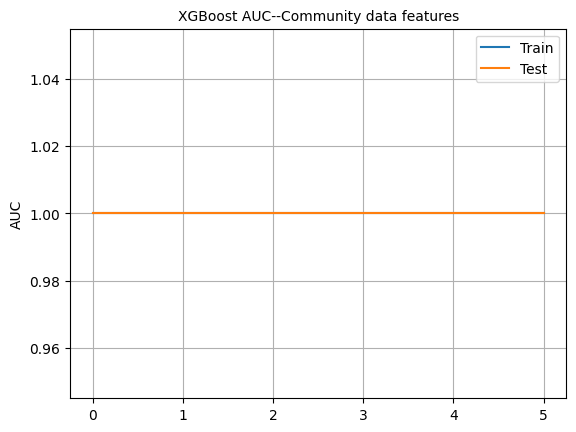

In [78]:
# 19.1 Learning curve: Modeling with transformed data:
#      We get results better than with all features:

results = model_trans_commu.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, np.round(results['validation_0']['auc'],3), label='Train');
ax.plot(x_axis, np.round(results['validation_1']['auc'],3), label='Test');
ax.legend();
ax.grid()
plt.ylabel('AUC');
plt.title('XGBoost AUC--Community data features', fontsize = 10);
plt.show();

### PCA of transformed data:

In [79]:
# 20.0 Impute train data:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy = "most_frequent")
fg_tr[0][:] = si.fit_transform(fg_tr[0])
fg_tr[0].head(3)

,a_projected_b.gml,a_projected_c.gml,a_projected_d.gml,a_projected_e.gml,a_projected_f.gml,b_projected_a.gml,b_projected_c.gml,b_projected_d.gml,b_projected_e.gml,b_projected_f.gml,...,e_projected_a.gml,e_projected_b.gml,e_projected_c.gml,e_projected_d.gml,e_projected_f.gml,f_projected_a.gml,f_projected_b.gml,f_projected_c.gml,f_projected_d.gml,f_projected_e.gml
4494,1,0,1,1,0,1,1,0,0,0,...,1,0,0,0,0,1,0,1,0,0
5879,1,0,1,1,0,1,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
851,1,0,1,1,0,1,0,0,0,0,...,1,0,1,0,0,1,0,1,0,0


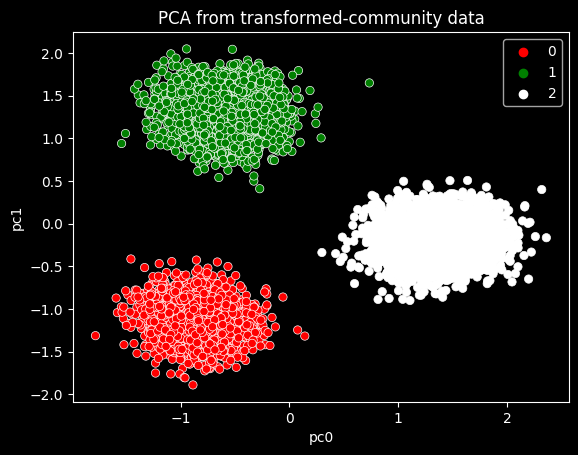

In [81]:
# 20.1 PCA next:
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
commu_pca = pca.fit_transform(ss.fit_transform(fg_tr[0]))
commu_pca.shape

# 20.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(trans_pca.shape[1])]
commu_pca = pd.DataFrame(commu_pca, columns = colnames)

# 20.3 PCA plot of transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= jitter(trans_pca.pc0, 0),
                y = jitter(trans_pca.pc1, 0),
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA from transformed-community data') ;

## Derive unit-vectors per level per cat column

In [ ]:
##*****************************
## Embedding Projector
##*****************************

### REad data

In [94]:
# 21.1.1
test_binned = pd.read_pickle(datafolder / "test_binned.pkl")
test_trans = pd.read_pickle(datafolder / "test_trans.pkl")

# 21.1.2
train_binned = pd.read_pickle(datafolder / "train_binned.pkl")
train_trans = pd.read_pickle(datafolder / "train_trans.pkl")

# 21.1.3
orig_test = pd.read_pickle(datafolder / "orig_test.pkl")
orig_train = pd.read_pickle(datafolder / "orig_train.pkl")

# 21.1.4
cat_cols = ['a', 'b', 'c', 'd', 'e', 'f']

# 21.1.5
y_train = train_binned['target'].reset_index(drop=True)
y_test = test_binned['target'].reset_index(drop = True)

# 21.1.6
ct = utils.restorePythonObject("transformer.pkl", datafolder)

In [95]:
# 21.2 Check for nulls:
train_trans.isnull().sum().sum()  # 0
print("---")
test_trans.isnull().sum().sum()   # 240

0

---


240

In [96]:
# 21.3 Impute test_trans
si = SimpleImputer(strategy = 'median')
si.fit(train_trans)
test_trans[:] = si.transform(test_trans)
# Check
test_trans.isnull().sum().sum()

SimpleImputer(strategy='median')

0

In [97]:
'target' in list(train_trans.columns)
'target' in list(test_trans.columns)

False

False

In [98]:
# 21.4 Get target data col.
#      Needed for generation of meta-data file:

test_trans['target'] = y_test
train_trans['target'] =  y_train

In [99]:
# 22.0 Derive unit vectors:

p = Path(unitvecfolder)
p.mkdir(parents=True, exist_ok=True)

vec_tr,_ = ct.vectorsToTSV(train_trans,
                           take_mean = False,
                           filepath = unitvecfolder,   # Folder where csv files will be saved
                           saveVectorsToDisk = True
                           )

print("\n----test data---\n")

# 22.1 Unit vectors from test data. But not being saved to file:
vec_te,_ = ct.vectorsToTSV(test_trans,
                           take_mean = False,
                           filepath = unitvecfolder,
                           impute = True,
                           saveVectorsToDisk = False
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for a
Checked for b
Checked for c
Checked for d
Checked for e
Checked for f
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: '/gdrive/MyDrive/Colab_data_files/makeblobs/unitvecfolder'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature

----test data---

Checking if vectors exist for all cat cols...
May take time...
Checked for a
Checked for b
Checked for c
Checked for d
Checked for e
Checked for f


## Save unit-vectors files to gdrive
Also save output dictionaries for later use

In [100]:
# 22.2 Save dict to gdrive:

utils.savePythonObject(vec_tr, "vec_tr.pkl", unitvecfolder)
utils.savePythonObject(vec_te, "vec_te.pkl",unitvecfolder)

Object saved to: /gdrive/MyDrive/Colab_data_files/makeblobs/unitvecfolder/vec_tr.pkl
Object saved to: /gdrive/MyDrive/Colab_data_files/makeblobs/unitvecfolder/vec_te.pkl


## Restore unit-vectors files from gdrive

In [101]:
# 22.3 Restore back:
vec_tr = utils.restorePythonObject( "vec_tr.pkl", unitvecfolder)
vec_te = utils.restorePythonObject("vec_te.pkl",unitvecfolder)

## Using unit vectors to transform train/test data

In [102]:
# 23.0 USe unit vectors to transform train/test data:

cctr,ccte, vtr,vte = utils.pcaAndConcat(vec_tr, vec_te, n_components = 4)


Performing PCA for a for train data
Performing PCA for a for test data
Performing PCA for b for train data
Performing PCA for b for test data
Performing PCA for c for train data
Performing PCA for c for test data
Performing PCA for d for train data
Performing PCA for d for test data
Performing PCA for e for train data
Performing PCA for e for test data
Performing PCA for f for train data
Performing PCA for f for test data
Concatenating train data
Concatenating test data
Done......


In [103]:
# 23.1

cctr.head(3)
ccte.head(3)

,pca0,pca1,pca2,pca3,pcb0,pcb1,pcb2,pcb3,pcc0,pcc1,...,pcd2,pcd3,pce0,pce1,pce2,pce3,pcf0,pcf1,pcf2,pcf3
0,5.890490,-3.482258,-1.911553,-0.942672,6.756805,-4.745082,-0.414008,-3.170006,-3.115528,-1.406003,...,5.917286,-1.829172,-0.041833,-0.099783,7.299470,-0.114257,-3.655717,-3.290811,0.451414,3.412047
1,7.065964,-2.720235,-1.715331,-1.036763,6.433849,-4.545083,0.780498,0.369740,-1.881917,-1.558490,...,4.059823,2.044364,-9.272874,-1.004459,1.766121,0.660084,-3.481307,0.039813,-4.033714,-1.663715
2,7.065964,-2.720208,-1.715318,-1.036841,7.110440,-4.360291,-0.484287,-0.579394,-5.251609,-3.484086,...,4.059786,2.044301,-12.408934,-1.562875,1.900706,-0.668821,-4.699788,9.025988,-1.030883,-1.043202


,pca0,pca1,pca2,pca3,pcb0,pcb1,pcb2,pcb3,pcc0,pcc1,...,pcd2,pcd3,pce0,pce1,pce2,pce3,pcf0,pcf1,pcf2,pcf3
0,-7.804055,-1.007613,1.329700,-0.662368,-0.523885,3.120226,-4.697218,-2.930738,8.882670,1.627501,...,-1.285300,-4.330938,1.061982,4.355806,-1.720655,0.362588,-3.369671,-4.055033,1.120609,3.067551
1,-8.040327,0.268613,-1.964731,-2.598704,-4.187109,-0.388484,4.503089,-0.692391,-3.115511,-1.405953,...,-1.380158,0.096164,4.550710,-4.095702,-2.025155,2.065463,4.804847,9.834214,-1.422959,-1.610179
2,-6.576797,-1.595882,2.614035,0.160312,-1.076691,3.423536,-4.576154,-1.148841,6.585808,1.027247,...,-3.220910,2.420690,-12.450075,0.297383,-3.629988,-0.706223,-3.501461,-1.778221,-1.003241,-1.073268


In [104]:
# 23.2

cctr.shape   #  (9000,24)
ccte.shape   #  (1000,24)

(9000, 24)

(1000, 24)

In [105]:
# 23.3

print(list(cctr.columns[:10]))
print(list(cctr.columns[10:]))


['pca0', 'pca1', 'pca2', 'pca3', 'pcb0', 'pcb1', 'pcb2', 'pcb3', 'pcc0', 'pcc1']
['pcc2', 'pcc3', 'pcd0', 'pcd1', 'pcd2', 'pcd3', 'pce0', 'pce1', 'pce2', 'pce3', 'pcf0', 'pcf1', 'pcf2', 'pcf3']


### Save unitvectors transformed train/test

In [107]:
# 23.4 Save cctr/ccte to gdrive
cctr.to_pickle(datafolder / "cctr.pkl")
ccte.to_pickle(datafolder / "ccte.pkl")

### Readback unitvectors transformed train/test

In [108]:
# 24.0 Read back cctr/ccte
cctr = pd.read_pickle(datafolder / "cctr.pkl")
ccte = pd.read_pickle(datafolder / "ccte.pkl")

# Check
cctr.head(2)
ccte.head(2)
cctr.shape # (9000,24)
ccte.shape # (1000,24)

,pca0,pca1,pca2,pca3,pcb0,pcb1,pcb2,pcb3,pcc0,pcc1,...,pcd2,pcd3,pce0,pce1,pce2,pce3,pcf0,pcf1,pcf2,pcf3
0,5.890490,-3.482258,-1.911553,-0.942672,6.756805,-4.745082,-0.414008,-3.170006,-3.115528,-1.406003,...,5.917286,-1.829172,-0.041833,-0.099783,7.299470,-0.114257,-3.655717,-3.290811,0.451414,3.412047
1,7.065964,-2.720235,-1.715331,-1.036763,6.433849,-4.545083,0.780498,0.369740,-1.881917,-1.558490,...,4.059823,2.044364,-9.272874,-1.004459,1.766121,0.660084,-3.481307,0.039813,-4.033714,-1.663715


,pca0,pca1,pca2,pca3,pcb0,pcb1,pcb2,pcb3,pcc0,pcc1,...,pcd2,pcd3,pce0,pce1,pce2,pce3,pcf0,pcf1,pcf2,pcf3
0,-7.804055,-1.007613,1.329700,-0.662368,-0.523885,3.120226,-4.697218,-2.930738,8.882670,1.627501,...,-1.285300,-4.330938,1.061982,4.355806,-1.720655,0.362588,-3.369671,-4.055033,1.120609,3.067551
1,-8.040327,0.268613,-1.964731,-2.598704,-4.187109,-0.388484,4.503089,-0.692391,-3.115511,-1.405953,...,-1.380158,0.096164,4.550710,-4.095702,-2.025155,2.065463,4.804847,9.834214,-1.422959,-1.610179


(9000, 24)

(1000, 24)

## xgboost modeling

In [110]:
# 24.1 Perform xgboost modeling using the above train/test data:

model_vec = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = None,
                              reg_lambda = 1.5,
                           )

tr_X =    cctr
test_X =  ccte
ytrain =  y_train
ytest = y_test


model_vec.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[02:53:54] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[02:53:54] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:53:54] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:53:54] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:1.00000	validation_1-auc:1.00000
[02:53:54] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:53:54] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:53:55] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:1.00000	validation_1-auc:1.00000
[02:53:55] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:53:55] INFO: ../src/tree/updater_prune.cc:98: 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [111]:
# 24.2 Best scores:

model_vec.best_score   # 1.0
print("\n")
model_vec.best_iteration  # 8


1.0

8

In [113]:
# 24.3 Classification report:

pred_vec = model_vec.predict(test_X)
print(classification_report(ytest,pred_vec))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       350
           1       1.00      1.00      1.00       344
           2       1.00      1.00      1.00       306

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



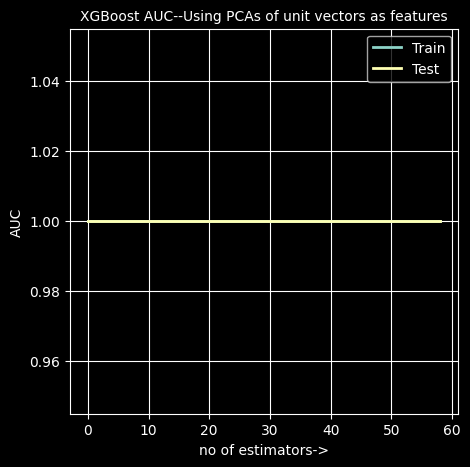

In [114]:
# 24.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_vec.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using PCAs of unit vectors as features", fontsize= 10);


## Feature Engineering with clustering

In [115]:
# 25.0 Create clustering features from unitvector dataframes:

n_components = 4  # No of components while performing PCA of every feature
fe_tr,fe_te = utils.featureEngKmeans(cctr,
                                     ccte,
                                     n_clusters = 4,  # No of clusters per feature
                                     step_size = n_components,
                                     km=True,  # Only perform KMeans
                                     gmm=False  # No Gaussian Mixture modeling
                                     )

Current index:  0
Current index:  4
Current index:  8
Current index:  12
Current index:  16
Current index:  20


In [116]:
# 25.1 Output is orig dataframe + clusters
fe_tr.head(3)
fe_te.head(3)

,pca0,pca1,pca2,pca3,pcb0,pcb1,pcb2,pcb3,pcc0,pcc1,...,pcf0,pcf1,pcf2,pcf3,clu0,clu1,clu2,clu3,clu4,clu5
0,5.890490,-3.482258,-1.911553,-0.942672,6.756805,-4.745082,-0.414008,-3.170006,-3.115528,-1.406003,...,-3.655717,-3.290811,0.451414,3.412047,1,0,0,3,3,1
1,7.065964,-2.720235,-1.715331,-1.036763,6.433849,-4.545083,0.780498,0.369740,-1.881917,-1.558490,...,-3.481307,0.039813,-4.033714,-1.663715,1,0,0,3,1,1
2,7.065964,-2.720208,-1.715318,-1.036841,7.110440,-4.360291,-0.484287,-0.579394,-5.251609,-3.484086,...,-4.699788,9.025988,-1.030883,-1.043202,1,0,0,3,1,0


,pca0,pca1,pca2,pca3,pcb0,pcb1,pcb2,pcb3,pcc0,pcc1,...,pcf0,pcf1,pcf2,pcf3,clu0,clu1,clu2,clu3,clu4,clu5
0,-7.804055,-1.007613,1.329700,-0.662368,-0.523885,3.120226,-4.697218,-2.930738,8.882670,1.627501,...,-3.369671,-4.055033,1.120609,3.067551,3,3,1,1,2,1
1,-8.040327,0.268613,-1.964731,-2.598704,-4.187109,-0.388484,4.503089,-0.692391,-3.115511,-1.405953,...,4.804847,9.834214,-1.422959,-1.610179,3,1,0,0,0,0
2,-6.576797,-1.595882,2.614035,0.160312,-1.076691,3.423536,-4.576154,-1.148841,6.585808,1.027247,...,-3.501461,-1.778221,-1.003241,-1.073268,3,3,1,1,1,1


In [117]:
# 25.2 Have a look at clusters created:

fe_tr[fe_tr.columns[-len(cat_cols):]].head()
fe_te[fe_te.columns[-len(cat_cols):]].head()


,clu0,clu1,clu2,clu3,clu4,clu5
0,1,0,0,3,3,1
1,1,0,0,3,1,1
2,1,0,0,3,1,0
3,3,3,1,1,2,1
4,3,3,1,1,2,1


,clu0,clu1,clu2,clu3,clu4,clu5
0,3,3,1,1,2,1
1,3,1,0,0,0,0
2,3,3,1,1,1,1
3,1,0,3,3,1,1
4,1,0,2,3,1,1


In [121]:
# 25.3 Perform xgboost modeling using only the above clusters:

model_fe = xgb.XGBClassifier( n_estimators= 100,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = None,
                              reg_lambda = 1.5,
                           )

tr_X =   fe_tr[fe_tr.columns[-len(cat_cols):]]
test_X =  fe_te[fe_te.columns[-len(cat_cols):]]
ytrain =  y_train
ytest = y_test


model_fe.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[02:58:49] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[02:58:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[02:58:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:58:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[0]	validation_0-auc:1.00000	validation_1-auc:1.00000
[02:58:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[02:58:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:58:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[1]	validation_0-auc:1.00000	validation_1-auc:1.00000
[02:58:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[02:58:49] INFO: ../src/tree/updater_prune.cc:98: 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [122]:
model_fe.best_score  # 1.0


1.0

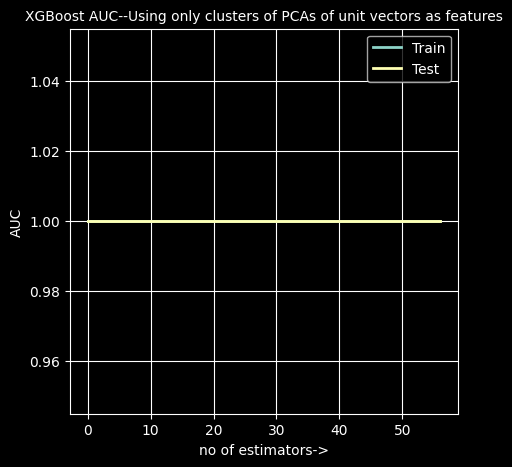

In [123]:
# 25.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_fe.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using only clusters of PCAs of unit vectors as features", fontsize = 10);


## Averaged unit vectors per level per feature
Unit vectors can be used look at clusters of features in Embedding Projector

In [124]:
# 26.0
train_trans['target'] = y_train

vec_trx , _ = ct.vectorsToTSV(train_trans,
                           take_mean = True,
                           filepath = unitvecfolder,   # Folder where csv files will be saved
                           saveVectorsToDisk = True,
                           fnamesuffix = "_avg"
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for a
Checked for b
Checked for c
Checked for d
Checked for e
Checked for f
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: '/gdrive/MyDrive/Colab_data_files/makeblobs/unitvecfolder'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature


In [ ]:
############# DONE ##################